In [2]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import heapq
import math

In [3]:
card_img = cv.imread("./card_distors.jpg")[:,:,::-1]

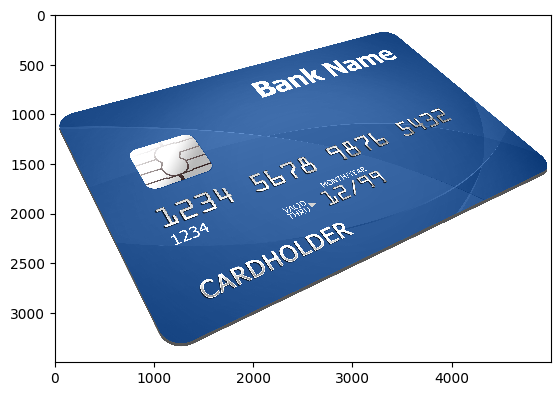

In [4]:
plt.imshow(card_img, interpolation = 'none')

**Roi extraction**

In [5]:
card_gray = cv.cvtColor(card_img, cv.COLOR_BGR2GRAY)
ret, card_bin = cv.threshold(card_gray, 0, 255,cv.THRESH_BINARY+cv.THRESH_OTSU)

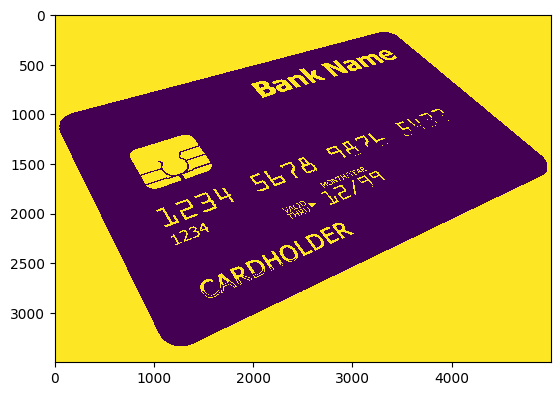

In [6]:
plt.imshow(card_bin, interpolation = 'none')

In [7]:
cmpts = cv.connectedComponentsWithStats( card_bin )

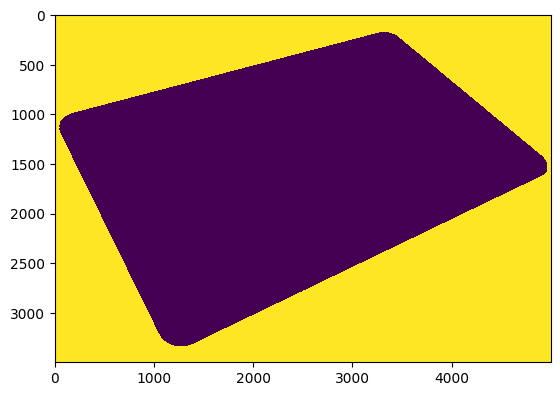

In [8]:
plt.imshow(cmpts[1] == 1, interpolation = 'none')

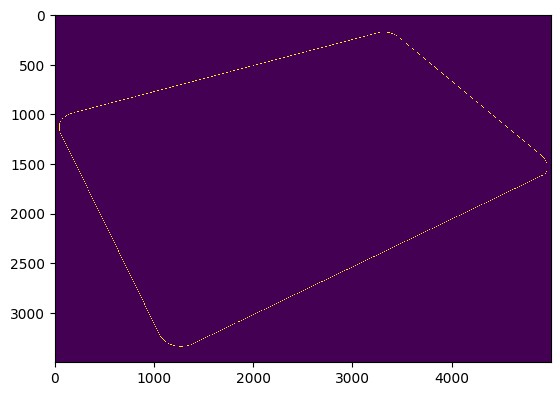

In [9]:
cpntours_img = np.zeros_like(card_bin, dtype=np.uint8)
card_mask = 1 - np.array(cmpts[1] == 1).astype(np.uint8).copy()
contours, _ = cv.findContours(card_mask, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
cv.drawContours(cpntours_img, contours, -1, 255, thickness=4)
plt.imshow(cpntours_img, interpolation = 'none')

In [10]:
contours[0].reshape((7961, 2))

array([[3294,  180],
       [3293,  181],
       [3282,  181],
       ...,
       [3314,  180],
       [3313,  181],
       [3312,  180]], dtype=int32)

In [11]:
def point_to_segment_distance(point, seg_start, seg_end):
    px, py = point
    x1, y1 = seg_start
    x2, y2 = seg_end
    
    dx, dy = x2 - x1, y2 - y1
    if dx == 0 and dy == 0:
        return np.linalg.norm([px - x1, py - y1])
    
    t = ((px - x1) * dx + (py - y1) * dy) / (dx * dx + dy * dy)
    t = max(0, min(1, t))
    
    closest_x = x1 + t * dx
    closest_y = y1 + t * dy
    
    return np.linalg.norm([px - closest_x, py - closest_y])

def are_segments_close(segment1, segment2, tolerance):
    p1, p2 = segment1
    q1, q2 = segment2
    
    return (
        point_to_segment_distance(p1, q1, q2) <= tolerance or
        point_to_segment_distance(p2, q1, q2) <= tolerance
    )


def merge_segments(segments, tolerance):
    merged_segments = []
    used = [False] * len(segments)
    
    for i, seg1 in enumerate(segments):
        if used[i]:
            continue
        segment1 = ([seg1[0][0], seg1[0][1]], [seg1[0][2], seg1[0][3]])
        current_start, current_end = segment1
        used[i] = True
        
        for j, seg2 in enumerate(segments):
            if i == j or used[j]:
                continue
            segment2 = ([seg2[0][0], seg2[0][1]], [seg2[0][2], seg2[0][3]])
            if are_segments_close(segment1, segment2, tolerance):
                used[j] = True
                current_start = min(current_start, segment2[0], segment2[1], key=lambda p: (p[0], p[1]))
                current_end = max(current_end, segment2[0], segment2[1], key=lambda p: (p[0], p[1]))
        
        merged_segments.append([[current_start[0], current_start[1], current_end[0], current_end[1]]])
    
    return merged_segments

In [12]:
def find_k_longest_segments(segments, k):
    heap = []
    
    for segment in segments:
        x1,y1,x2,y2 = segment[0]
        start, end = np.array([x1,y1]), np.array([x2,y2])
        length = np.linalg.norm(end - start)
        start_tuple = tuple([x1,y1])
        end_tuple = tuple([x2,y2])
        
        if len(heap) < k:
            heapq.heappush(heap, (length, start_tuple, end_tuple))
        else:
            if length > heap[0][0]:
                heapq.heappushpop(heap, (length, start_tuple, end_tuple))
    
    result = sorted(heap, key=lambda x: -x[0])
    
    return [[[start_tuple[0], start_tuple[1], end_tuple[0], end_tuple[1]]] for length, start_tuple, end_tuple in result]

In [13]:
def sort_segments_by_polar_angle(segments, center):
    cx, cy = center

    def polar_angle(point):
        x, y = point
        dx = x - cx
        dy = y - cy
        return math.atan2(dy, dx)

    sorted_segments = sorted(segments, key=lambda seg: polar_angle(seg[0][0:2]))
    return sorted_segments

(56, 1, 4)
16


[[[np.int32(43), np.int32(1166), np.int32(1066), np.int32(3249)]],
 [[np.int32(141), np.int32(1007), np.int32(3184), np.int32(205)]],
 [[np.int32(3763), np.int32(483), np.int32(4920), np.int32(1447)]],
 [[np.int32(1375), np.int32(3323), np.int32(4931), np.int32(1607)]]]

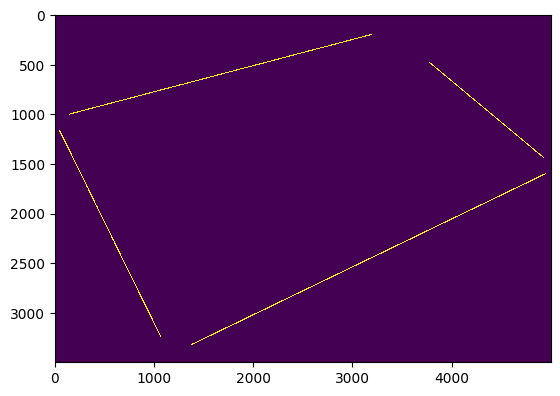

In [14]:
edges = cv.Canny(card_bin,50,150,apertureSize = 3)
houghLines = cv.HoughLinesP(cpntours_img,4,np.pi/180,80,minLineLength=200,maxLineGap=30)
contours_draw_img = np.zeros_like(card_bin, dtype=np.uint8)
print(houghLines.shape)
houghLines = merge_segments(houghLines, 6)
houghLines = merge_segments(houghLines, 6)
print(len(houghLines))
houghLines = find_k_longest_segments(houghLines, 4)
houghLines = sort_segments_by_polar_angle(houghLines, (card_bin.shape[1] // 2, card_bin.shape[0] // 2))
for line in houghLines:
    x1,y1,x2,y2 = line[0]
    cv.line(contours_draw_img,(x1,y1),(x2,y2),1,10)
plt.imshow(contours_draw_img, interpolation = 'none')
# houghLines = houghLines.reshape((238, 4))
houghLines

In [15]:

def find_intersection(segment1, segment2):
    x1, y1 = segment1[0], segment1[1]
    x2, y2 = segment1[2], segment1[3]
    x3, y3 = segment2[0], segment2[1]
    x4, y4 = segment2[2], segment2[3]
    
    det = (x1 - x2) * (y3 - y4) - (y1 - y2) * (x3 - x4)
    
    if np.isclose(det, 0):
        return None
    
    t = ((x1 - x3) * (y3 - y4) - (y1 - y3) * (x3 - x4)) / det
    u = ((x1 - x3) * (y1 - y2) - (y1 - y3) * (x1 - x2)) / det
    px = x1 + t * (x2 - x1)
    py = y1 + t * (y2 - y1)
    return px, py

In [16]:
source = np.zeros((4, 2))
length = len(houghLines)
for i in range(length):
    source[i] = np.array(find_intersection(houghLines[i][0], houghLines[(i + 1) % length][0]), np.float32)

source

array([[ -14.90762329, 1048.09033203],
       [3370.38476562,  155.87722778],
       [5045.63769531, 1551.67993164],
       [1154.58129883, 3429.36621094]])

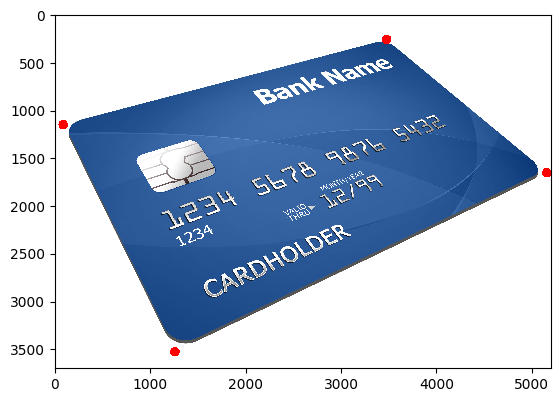

In [17]:
card_img_padded = 255*np.ones((card_img.shape[0] + 200, card_img.shape[1] + 200, 3), np.uint8)
card_img_padded[100:(100 + card_img.shape[0]), 100:(100 + card_img.shape[1]), :] = card_img
for i in range(4):
    source[i][0] += 100
    source[i][1] += 100
card_img_padded_draw = card_img_padded.copy()
for pt in source:
    cv.circle(card_img_padded_draw, pt.astype(np.int32), 50, (255, 0, 0), -1)
plt.imshow(card_img_padded_draw, interpolation = 'none')

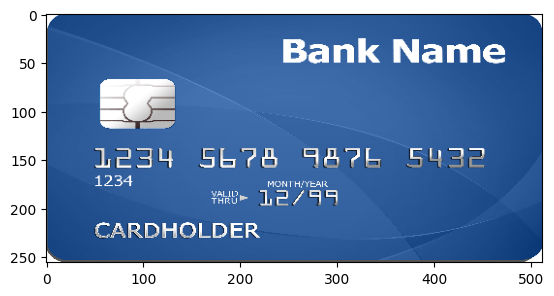

In [18]:
source = source.astype(np.float32)
target = np.float32([[0,0],\
             [512,0],\
             [512,256],\
             [0,256]])
M = cv.getPerspectiveTransform(source, target)
roi_img = cv.warpPerspective(card_img_padded, M, (512,256))
plt.imshow( roi_img )

**Numbers recognition**

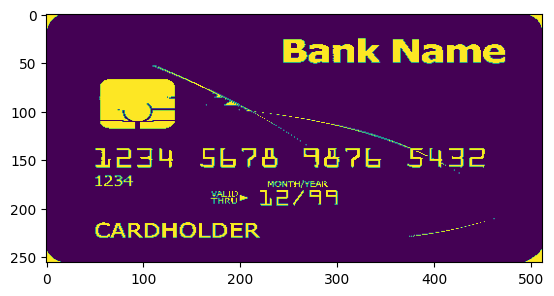

In [19]:
roi_img_gray = cv.cvtColor(roi_img, cv.COLOR_BGR2GRAY)
_, roi_img_bin = cv.threshold(roi_img_gray, 127, 255, cv.THRESH_BINARY)
plt.imshow( roi_img_bin )

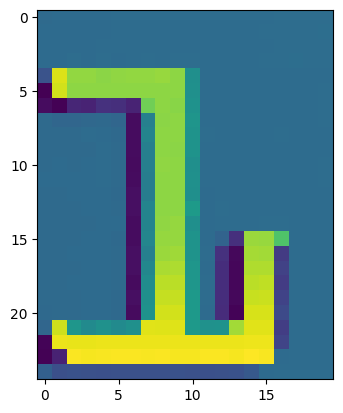

In [20]:
# roi_img_gray[135:160, 50:70, :][12, 7, :]
plt.imshow( roi_img_gray[135:160, 50:70] )

In [21]:
def load_and_make_gray(image_path):
    img = cv.imread(image_path, cv.IMREAD_GRAYSCALE)
    _, bin_img = cv.threshold(img, 128, 255, cv.THRESH_BINARY_INV)
    return (bin_img)

def create_mask(template):
    mask = np.zeros_like(template, dtype=np.uint8)
    contours, _ = cv.findContours(template, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
    cv.drawContours(mask, contours, -1, 255, thickness=cv.FILLED)
    mask = cv.bitwise_not(mask)
    return 255 - mask

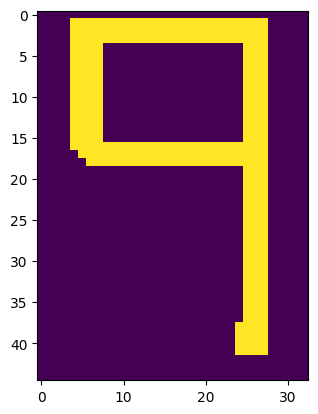

In [22]:
templates = {}
for digit in range(1, 10):
    template_path = f"tpl_{digit}.png"
    tmpl = load_and_make_gray(template_path)
    tmpl_mask = None
    plt.imshow(tmpl)
    templates[digit] = (tmpl, tmpl_mask)

In [35]:
def find_best_scale_and_detect_digits(main_image, templates):
    """Find the best scale using pyramid scaling and detect digits."""
    scales = [1.0, 1.25, 1.5, 1.75, 1.9, 2.0, 2.1, 2.25, 2.5, 2.6, 2.7, 2.8]  # Possible scales to test
    best_scale = 1.0
    threshold = 0.9
    best_matches = []

    for digit, (tmpl, mask) in templates.items():
        best_matches.append((0, digit, (0, 0), (0, 0)))
    
    for scale in scales:
        scaled_img = cv.resize(main_image, None, fx=scale, fy=scale, interpolation=cv.INTER_LINEAR)
        scale_matches = []

        for digit, (tmpl, mask) in templates.items():
            res = cv.matchTemplate(scaled_img, tmpl, cv.TM_CCORR_NORMED, mask=mask)
            min_val, max_val, min_loc, max_loc = cv.minMaxLoc(res)
            top_left = max_loc
            bottom_right = (top_left[0] + tmpl.shape[1], top_left[1] + tmpl.shape[0])
            scale_matches.append((max_val, digit, top_left, bottom_right))
            res[res == max_val] = 0
            min_val, max_val, min_loc, max_loc = cv.minMaxLoc(res)
            top_left = max_loc
            bottom_right = (top_left[0] + tmpl.shape[1], top_left[1] + tmpl.shape[0])
            scale_matches.append((max_val, digit, top_left, bottom_right))

        if sum(match[0] for match in scale_matches) > sum(match[0] for match in best_matches):
            best_scale = scale
            best_matches = scale_matches

    return best_scale, best_matches


def find_best_scale_and_detect_digits_new(main_image, templates):
    scales = [1.0, 1.25, 1.5, 1.75, 1.9, 2.0, 2.1, 2.25, 2.5, 2.6, 2.7, 2.8]  # Possible scales to test
    best_scale = 1.0
    threshold = 0.9
    final_matches = []
    final_scales = []
    
    for digit, (tmpl, mask) in templates.items():
        best_matches = []
        best_scale = 1.0
        best_matches.append((0, digit, (0, 0), (0, 0)))
        for scale in scales:
            scaled_img = cv.resize(main_image, None, fx=scale, fy=scale, interpolation=cv.INTER_LINEAR)
            scale_matches = []
            res = cv.matchTemplate(scaled_img, tmpl, cv.TM_CCOEFF_NORMED, mask=mask)
            min_val, max_val, min_loc, max_loc = cv.minMaxLoc(res)
            top_left = max_loc
            bottom_right = (top_left[0] + tmpl.shape[1], top_left[1] + tmpl.shape[0])
            scale_matches.append([max_val, digit, top_left, bottom_right])
            min_val, max_val, min_loc, max_loc = cv.minMaxLoc(res)
            top_left = max_loc
            bottom_right = (top_left[0] + tmpl.shape[1], top_left[1] + tmpl.shape[0])
            scale_matches.append([max_val, digit, top_left, bottom_right])
            if sum(match[0] for match in scale_matches) > sum(match[0] for match in best_matches):
                best_matches = scale_matches
                best_scale = scale

        for match in best_matches:
            match += [best_scale]
            final_matches.append(match)

    return final_matches

In [24]:
def plot_results(main_image, detected_positions, scale = 1.0):
    """Plot the results with rectangles and digit labels."""
    scaled_img = cv.resize(main_image, None, fx=scale, fy=scale, interpolation=cv.INTER_LINEAR)

    best_scale = 1.0
    for _, digit, top_left, bottom_right in detected_positions:
        top_left = [int(val/best_scale) for val in top_left]
        bottom_right = [int(val/best_scale) for val in bottom_right]
        cv.rectangle(scaled_img, top_left, bottom_right, (255, 0, 0), 2)
        cv.putText(scaled_img, str(digit), (top_left[0], top_left[1] - 5), cv.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1)

    plt.imshow(scaled_img, cmap='gray')
    plt.title("Detected Digits")
    plt.axis('off')
    plt.show()

In [36]:
best_scale, detected_positions = find_best_scale_and_detect_digits(roi_img_bin, templates)
best_scale, detected_positions

# detected_positions = find_best_scale_and_detect_digits(roi_img_bin, templates)
# detected_positions

(2.0,
 [(0.7369703650474548, 1, (98, 274), (137, 324)),
  (0.7302289605140686, 1, (97, 274), (136, 324)),
  (0.6847040057182312, 2, (144, 274), (179, 324)),
  (0.6840512156486511, 2, (143, 274), (178, 324)),
  (0.7903966903686523, 3, (191, 275), (222, 321)),
  (0.7858244180679321, 3, (192, 275), (223, 321)),
  (0.7634442448616028, 4, (790, 278), (819, 321)),
  (0.7582204341888428, 4, (791, 278), (820, 321)),
  (0.7604348063468933, 5, (318, 276), (350, 322)),
  (0.7505441904067993, 5, (319, 276), (351, 322)),
  (0.7659009695053101, 6, (656, 275), (694, 323)),
  (0.7658235430717468, 6, (655, 275), (693, 323)),
  (0.7998008131980896, 7, (402, 277), (436, 321)),
  (0.7984487414360046, 7, (616, 277), (650, 321)),
  (0.7647113800048828, 8, (571, 276), (609, 323)),
  (0.7562853693962097, 8, (572, 276), (610, 323)),
  (0.7328202128410339, 9, (472, 377), (505, 422)),
  (0.7062458395957947, 9, (471, 377), (504, 422))])

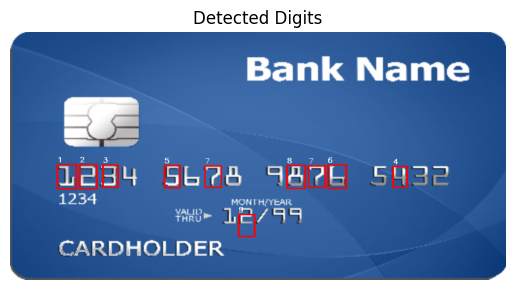

In [37]:
plot_results(roi_img, detected_positions, best_scale)